<a href="https://colab.research.google.com/github/mansibvb/O4-Rental-Car/blob/main/Rental_Car_RM_LEARNER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Revenue Management for the Rental Car Industry: O4A Hands-On Modeling
In this tutorial we will apply the principles of Revenue Management (RM) to a series of scenarios in the rental car industry. With each scenario, we will introduce an additional layer of complexity, adding more realism as we progress.

## Prelude
In this section we will simply import the needed Python packages and build a few functions that will be used throughout the examples that follow.

**NOTE**: No need to look deeply at this - simply run it and move on to the first scenario.


test

In [ ]:
# load data to folder
! git clone https://github.com/chrisgarcia001/Rental-Car-Revenue-Management

Cloning into 'Rental-Car-Revenue-Management'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 31 (delta 14), reused 1 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 158.70 KiB | 9.33 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
#install packages
!pip install pulp pandas numpy matplotlib

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# Import necessary libraries.
from pulp import *
import pandas as pd
import numpy as np
import random as rnd
import functools as ft
import matplotlib.pyplot as plt

# This returns a dict of solved indexed variables of the given name from a PuLP model.
# For example, suppose the model has variable x of form x_i_j. Then if x_2_5 = 8 in
# the solved model, the resulting dict d would have a key (2,5) with value 8.
# param model: A PuLP model
# param var_name: The variable name
# returns: A dict of form {index:value}
def get_solved_model_vars(model, var_name):
    vvs = {}
    for v in model.variables():
        if v.name.startswith(var_name):
            vvs[tuple(v.name.split('_')[1:])] = v.varValue
    return vvs

# For a demand data frame and solved model, attaches columns with prescribed allocation
# of each car class to each booking slot.
# param demand_data_df: A data frame containing demand data
#                        (Car Class, Rent Day, Return Day, Price, and Demand)
# param solved_model: A solved PuLP model
# returns: A data frame with car class columns and corresponding allocations
#          for each booking slot
def add_allocations(demand_data_df, solved_model):
    df = demand_data_df.copy()
    car_classes = set(df['Car Class'].tolist())
    booking_slots = list(range(1, len(df) + 1))
    x = get_solved_model_vars(solved_model, 'x')
    for h in car_classes:
        vals = []
        for k in booking_slots:
            vals.append(x[h,str(k)])
        df[h] = vals
    return df

## Scenario 1: Single-Location Rental Car Revenue Management
In this scenario, we optimize capacity allocation for a single-location car rental business. We begin by reading in the demand and pricing data and exploring it.
#### 1.1 Specify Initial Car Inventories and Substitution Schemes, Read in Demand Data

In [ ]:
# Specify the initial car inventory
init_car_inventory = {'Compact':35, 'Midsize':85, 'Luxury':50}

# Specify two different substitution schemes: 1) No substitutions, and 2) Upgrades allowed
no_subs = []
upgrades = [('Compact', 'Midsize'), ('Compact', 'Luxury'), ('Midsize', 'Luxury')]

# Read in and explore the single location scenario data.
single_loc_data = pd.read_csv('Rental-Car-Revenue-Management/single-loc-rm.csv')
single_loc_data.head()

,Car Class,Rent Day,Return Day,Demand,Price
0,Compact,1,2,16,50
1,Compact,1,3,20,102
2,Compact,1,4,7,129
3,Midsize,1,2,12,63
4,Midsize,1,3,21,110


#### 1.2 View a Summary of the Demand Pattern

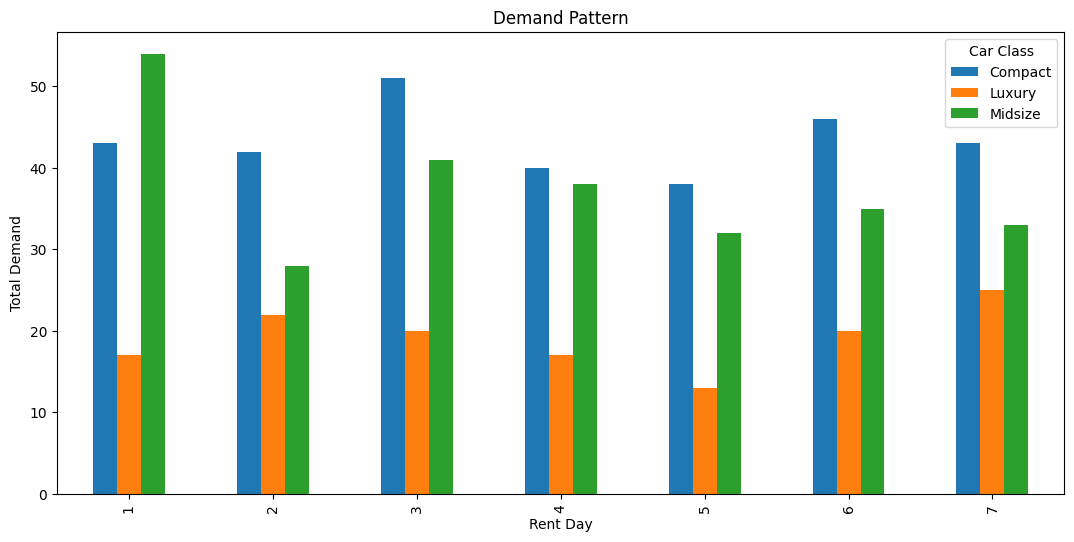

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# Transform the data for plotting
ag = single_loc_data[['Rent Day', 'Car Class', 'Demand']].groupby(['Car Class', 'Rent Day'], as_index=False).agg('sum')
pv = ag[['Car Class', 'Rent Day', 'Demand']].pivot_table(index='Rent Day', columns='Car Class', values='Demand')
pv.plot.bar(figsize = (13, 6))

# Create the plot and add chart info
plt.title('Demand Pattern')
plt.ylabel('Total Demand')

# Display the plot
plt.show()

#### 1.3 Create a Function to Transform Raw Data Into Model Inputs
In order to build our model, we must first transform the raw data into the appropriate inputs required by our model.

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# This function builds the inputs needed for the single-location RM model.
# param demand_data_df: A data frame containing demand data
#                       (Car Class, Rent Day, Return Day, Price, and Demand)
# param init_inventory: A dict of inventory for each car class
#                      (ex. {'Compact':35, 'Midsize':85, 'Luxury':50})
# param substitutes: a list of form [(X, Y), ...] where X and Y are car
#                     classes and Y can be substituted for X
# returns: A tuple of input values in the order required by the model
def build_single_loc_model_inputs(demand_data_df, init_inventory, substitutes):
    df = demand_data_df
    car_classes = set(df['Car Class'].tolist())
    booking_slots = list(range(1, len(df) + 1))
    delta = max(df['Rent Day'].tolist())
    price = {k:p for (k,p) in zip(booking_slots, df['Price'].tolist())}
    demand = {k:d for (k,d) in zip(booking_slots, df['Demand'].tolist())}
    D, A = {}, {}
    for j in range(1, delta + 1):
        D[j] = [k for k in booking_slots if df.loc[k-1, 'Rent Day'] == j]
        A[j] = [k for k in booking_slots if df.loc[k-1, 'Return Day'] == j]
    subs = {h:[j for (i, j) in substitutes + [(k,k) for k in car_classes] if i == h] for h in car_classes}
    satisfy = {(h,k):0 for h in car_classes for k in booking_slots}
    for k in booking_slots:
        base_class = df.loc[k-1, 'Car Class']
        for h in subs[base_class]:
            satisfy[h,k] = 1
    return car_classes, booking_slots, delta, price, demand, D, A, init_inventory, satisfy

#### 1.4 Create a Function to Construct a PuLP Model Instance from a Set of Inputs
Once we have the model inputs in an appropriate form, we need to build them into a PuLP model instance that can be solved.  
**TODO:** In the code block below, please complete the model implementation. Make sure to follow instructions on what to modify.

In [ ]:
# This function creates a PuLP model for the single-location scenario.
# param C: The set of car classes. A list or set.
# param S: The set of booking slots. A list or set.
# param delta: The number of days in the planning horizon (last rent day). An integer.
# param p: The price for each booking slot. A list.
# param d: The demand for each booking slot. A list.
# param D: A dict of form {<rental day>:[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots rent out cars on each day.
# param A: A dict of form {<arrival day>:[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots have cars being returned on each day.
# param I0: A dict of form {<car class>:units} - specifies how many cars of each type we have
#            at the beginning of the horizon
# param v: A dict of form {(<car_class>, <booking_slot>):B} where B = 0 | 1. Specifies
#           whether a car class can be allocated to a booking slot.
# returns: a PuLP model
def build_single_loc_model(C, S, delta, p, d, D, A, I0, v):
    # Compute a tight Big M:
    M = max(d)

    # Specify the decision variables:
    x = LpVariable.dicts("x", (C, S), 0, None, LpInteger)
    I = LpVariable.dicts("I", (C, list(range(delta+1))), 0, None, LpInteger)

    # Initialize the model and specify the objective function (exp. 1):
    mod = LpProblem("SingleLocRC", LpMaximize)
    mod += lpSum(p[k] * x[h][k] for h in C for k in S), 'TotalRevenue'

    for k in S:
        # Constraint set 2 - Don't allocate more cars than demand to any booking slot:
        mod += lpSum(x[h][k] for h in C) <= d[k]

    for h in C:
        for k in S:
            # Constraint set 3 - Ensure no invalid substitutions:
            mod += x[h][k] <= M * v[h,k]

        # Set initial inventories
        mod += I[h][0] == I0[h]

        for j in range(1, delta+1):
            # Constraint set 4 - Inventory flow balance
            mod += I[h][j] == I[h][j-1] - lpSum(x[h][k] for k in D[j]) + lpSum(x[h][k] for k in A[j])

    return mod

#### 1.4 Construct and Solve Two Models: With and Without Upgrade Substitutions
Below we will create and solve two models for the single-location scenario: with and without allowing upgrade substitutions (i.e., allowing higher-class cars to fill demand for lower-class cars when it is advantageous). It will be instructive to see the difference that can result from these two policies. We will compare these differences in a sub-section below.

In [ ]:
# Create a model that allows upgrades
upgrade_model_inputs = build_single_loc_model_inputs(single_loc_data, init_car_inventory, upgrades)
upgrade_model = build_single_loc_model(*upgrade_model_inputs)

# Create another model that does not allow upgrades
no_upgrade_model_inputs = build_single_loc_model_inputs(single_loc_data, init_car_inventory, no_subs)
no_upgrade_model = build_single_loc_model(*no_upgrade_model_inputs)

# Solve the models - by default PuLP will use the CBC solver
upgrade_model.solve()
no_upgrade_model.solve()

# Print the revenues
print('Total Profit (Upgrade Model): ' + str(f"${value(upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[upgrade_model.status])
print('Total Profit (Non-Upgrade Model): ' + str(f"${value(no_upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[no_upgrade_model.status])

Total Profit (Upgrade Model): $86,951.00 --- Status: Optimal
Total Profit (Non-Upgrade Model): $82,023.00 --- Status: Optimal


#### 1.5 Examine the Prescribed Allocation to the Upgrade Cars

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

alloc_df=add_allocations(single_loc_data, upgrade_model)
alloc_df.head()

,Car Class,Rent Day,Return Day,Demand,Price,Compact,Midsize,Luxury
0,Compact,1,2,16,50,11.0,5.0,0.0
1,Compact,1,3,20,102,17.0,0.0,3.0
2,Compact,1,4,7,129,7.0,0.0,0.0
3,Midsize,1,2,12,63,0.0,12.0,0.0
4,Midsize,1,3,21,110,0.0,21.0,0.0


#### 1.6 Simulating the Human Way: First-Come-First-Served (FCFS)
In order to see the benefit of RM, it is helpful to compare the results of RM to those obtained way a human might do this without the aid of a computer. With this approach, orders in the order they come and upgrades are not used so as to ensure they are available for higher-paying customers that might come later. Thus, this policy can be summarized as First-Come-First-Served (FCFS) without upgrades.

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# This function simulates the way a human would allocte capacity in a single-location
# rental car scenario without RM - on a first-come-first-served basis and without substitutions.
# param demand_data_df: A data frame containing demand data
#                       (Car Class, Rent Day, Return Day, Price, and Demand)
# param car_inventory: A dict of inventory for each car class
#                      (ex. {'Compact':35, 'Midsize':85, 'Luxury':50})
# param randomize: True | False. Specifies whether to randomize the order of requests
# returns: The resulting revenue generated by this approach
def FCFS_single_loc(demand_data_df, car_inventory, randomize=False):
    df = demand_data_df
    overlap = {i:[] for i in range(len(df))}
    for i in range(len(df)):
        for j in range(len(df)):
            a1, b1 = df.loc[i,'Rent Day'], df.loc[i,'Return Day']
            a2, b2 = df.loc[j, 'Rent Day'], df.loc[j, 'Return Day']
            if not((b2 < a1) or (b1 < a2) or (df.loc[i,'Car Class'] != df.loc[j,'Car Class'])):
                overlap[i].append(j)
    cap = [car_inventory[df.loc[i,'Car Class']] for i in range(len(df))]
    dem = df['Demand'].tolist()
    price = df['Price'].tolist()
    requests = ft.reduce(lambda x,y: x+y, [[i for j in range(dem[i])] for i in range(len(df))])
    requests = rnd.sample(requests, len(requests)) if randomize else requests
    revenue = 0
    for r in requests:
        if cap[r] > 0:
            revenue += price[r]
            for s in overlap[r]:
                cap[s] = max(0, cap[s]-1)
    return revenue

#### 1.7 An Experiment: Comparing Policies
In an effort to see how different RM vs. non-RM approaches can impact revenues, we will conduct an experiment. We will run the FCFS method 20 times - each with a randomized request order - and compare the revenues to those obtained by the upgrade and no-upgrade RM models we created above.

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# Simulate a human solving the problem over repeated instances.
fcfs_results = [FCFS_single_loc(single_loc_data, init_car_inventory, randomize=True) for i in range(20)]

Now we can graph and compare the results:

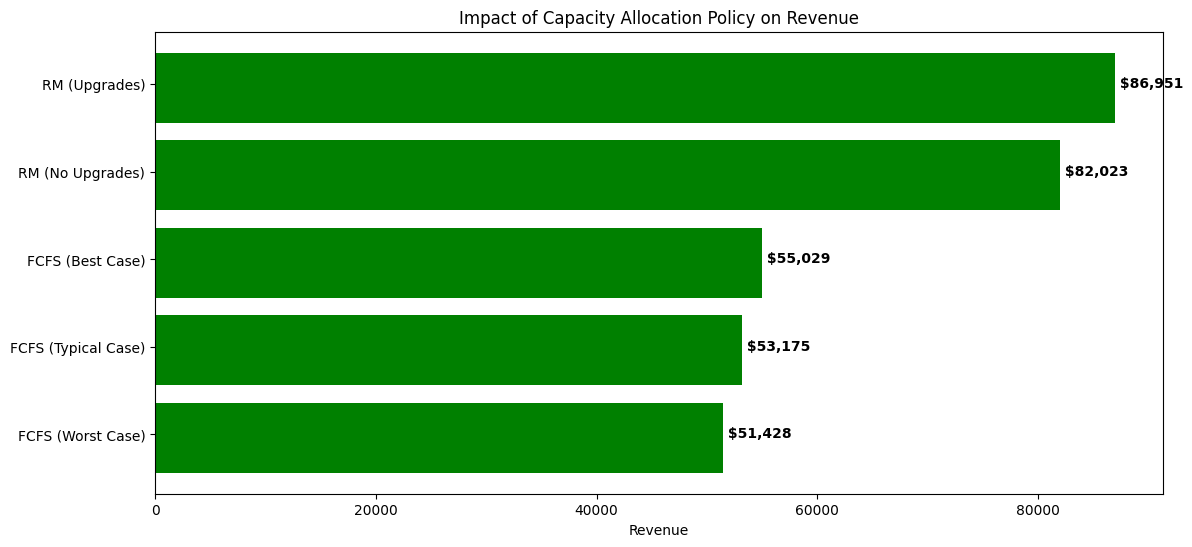

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

x = ['FCFS (Worst Case)', 'FCFS (Typical Case)', 'FCFS (Best Case)',
     'RM (No Upgrades)', 'RM (Upgrades)']
y = [min(fcfs_results), np.median(fcfs_results), max(fcfs_results),
     value(no_upgrade_model.objective), value(upgrade_model.objective)]

fig, ax = plt.subplots(figsize = (13, 6))
width = 0.8 # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="green", align='center')
ax.set_yticks(ind+width/20)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(y):
    ax.text(v, i, str(" ${:,}".format(round(int(v), 0))),
            color='black', fontweight='bold')
plt.title('Impact of Capacity Allocation Policy on Revenue')
plt.xlabel('Revenue')
plt.ylabel('')
plt.show()

## Scenario 2: Basic Multi-Location Rental Car Revenue Management
In this scenario, we optimize capacity allocation for a car rental business that has multiple locations. For now we will use a simplifying assumption of per-vehicle transfer costs between locations, and will proceed to more realistic tranfers in a subsequent scenario. We begin by reading in the demand and pricing data and exploring it.

#### 2.1 Create a Function to Transform Raw Data Into Model Inputs
As we did in the single-location scenario, we must first transform the raw data into the appropriate inputs required by our model.

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# This function builds the inputs needed for the basic multi-location RM model.
# param demand_data_df: A data frame containing demand data
#                       (Location, Car Class, Rent Day, Return Day, Price, and Demand)
# param init_inventory: A dict specifying initial inventory at each location of each car class.
#                      (ex. {('Fredericksburg, 'Compact'):35, ('Arlington','Midsize'):85})
# param transfer_costs: A dict of form {(<car class>, <from location>, <to location>):<cost>}.
#                        Specifies the transfer cost for each car class between every pair of locations.
# param substitutes: a list of form [(X, Y), ...] where X and Y are car
#                     classes and Y can be substituted for X
# returns: A tuple of input values in the order required by the model
def build_basic_multi_loc_model_inputs(demand_data_df, init_inventory, transfer_costs, substitutes):
    df = demand_data_df
    car_classes = set(df['Car Class'].tolist())
    locations = set(df['Location'].tolist())
    booking_slots = list(range(1, len(df) + 1))
    delta = max(df['Rent Day'].tolist())
    price = {k:p for (k,p) in zip(booking_slots, df['Price'].tolist())}
    demand = {k:d for (k,d) in zip(booking_slots, df['Demand'].tolist())}
    D, A = {}, {}
    for i,j in [(a,b) for a in locations for b in range(1, delta + 1)]:
        D[i,j] = [k for k in booking_slots if df.loc[k-1, 'Location'] == i and df.loc[k-1, 'Rent Day'] == j]
        A[i,j] = [k for k in booking_slots if df.loc[k-1, 'Location'] == i and df.loc[k-1, 'Return Day'] == j]
    subs = {h:[j for (i, j) in substitutes + [(k,k) for k in car_classes] if i == h] for h in car_classes}
    satisfy = {(h,k):0 for h in car_classes for k in booking_slots}
    for k in booking_slots:
        base_class = df.loc[k-1, 'Car Class']
        for h in subs[base_class]:
            satisfy[h,k] = 1
    return car_classes, locations, booking_slots, delta, price, demand, transfer_costs, D, A, init_inventory, satisfy

#### 2.2 Create a Function to Construct a PuLP Model Instance from a Set of Inputs
Once we have the model inputs in an appropriate form, we need to build them into a PuLP model instance that can be solved.  
**TODO:** In the code block below, please complete the model implementation. Make sure to follow instructions on what to modify.

In [ ]:
# This function creates a PuLP model for the basic multi-location scenario.
# param C: The set of car classes. A list or set.
# param L: The set of locations. A list or set.
# param S: The set of booking slots. A list or set.
# param delta: The number of days in the planning horizon (last rent day). An integer.
# param p: The price for each booking slot. A list.
# param d: The demand for each booking slot. A list.
# param c: The vehicle transfer costs. A dict of form {(<car class>, <from location>, <to location>):<cost>}
# param D: A dict of form {(<location>, <rental day>):[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots rent out cars on each day.
# param A: A dict of form {(<location>, <arrival day>):[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots have cars being returned on each day.
# param I0: A dict of form {(<car class>, <location>):units} - specifies how many cars of each type we have
#            at each location at the beginning of the horizon
# param v: A dict of form {(<car_class>, <booking_slot>):B} where B = 0 | 1. Specifies
#           whether a car class can be allocated to a booking slot.
# returns: a PuLP model
def build_basic_multi_loc_model(C, L, S, delta, p, d, c, D, A, I0, v):
    # Compute a tight Big M:
    M = max(d)

    # Specify the decision variables:
    x = LpVariable.dicts("x", (C, S), 0, None, LpInteger)
    I = LpVariable.dicts("I", (C, L, list(range(delta+1))), 0, None, LpInteger)
    # --- TODO: Add an LPVariable.dicts for the "t" variable here. Its values should be integer >= 0
    #           and it should be indexed over (C, L, L, 0..delta-1). Use the above as examples.

    # Initialize the model and specify the objective function (exp. 1):
    mod = LpProblem("BasicMultiLocRC", LpMaximize)
    mod += (lpSum(p[k] * x[h][k] for h in C for k in S)
            # --- TODO: Insert code here to subtract the cost expression
           ), 'Profit'

    for k in S:
        # Constraint set 2 - Don't allocate more cars than demand to any booking slot:
        mod += lpSum(x[h][k] for h in C) <= d[k]
    for h in C:
        for k in S:
            # Constraint set 3 - Ensure no invalid substitutions:
            mod += x[h][k] <= M * v[h,k]
        for i in L:
            # Set initial inventories
            mod += I[h][i][0] == I0[h,i]
            for j in range(1, delta+1):
                # Constraint set 4 - Inventory flow balance
                # --- TODO: Insert code here to implement the flow balance constraint
                for j in range(delta):
                    # Constraint 5: Don't transfer out more cars than are available at each location.
                    # --- TODO: Insert code here to implement this constraint
                    pass
    return mod

#### 2.3 Read in Demand Data and Specify Initial Inventories & Transfer costs

In [ ]:
# Read in the demand data for the multi-location scenario and view
multi_loc_data = pd.read_csv('Rental-Car-Revenue-Management/multi-loc-rm.csv')
multi_loc_data.head()

,Location,Car Class,Rent Day,Return Day,Demand,Price
0,Fredericksburg,Compact,1,2,14,44
1,Fredericksburg,Compact,1,3,21,86
2,Fredericksburg,Compact,1,4,9,135
3,Fredericksburg,Midsize,1,2,10,63
4,Fredericksburg,Midsize,1,3,13,128


In [ ]:
# Construct the initial car inventories
init_car_inventory = {('Compact','Fredericksburg'):35, ('Midsize','Fredericksburg'):85, ('Luxury','Fredericksburg'):90,
                      ('Compact','Charlottesville'):15, ('Midsize','Charlottesville'):35, ('Luxury','Charlottesville'):20,
                      ('Compact','Arlington'):35, ('Midsize','Arlington'):35, ('Luxury','Arlington'):50}

# Construct the transfer costs - a flat fee of $100 per transfer
locs = ['Fredericksburg', 'Charlottesville', 'Arlington']
classes = ['Compact', 'Midsize', 'Luxury']
transfer_costs = {(h,i,j):0 if i == j else 100 for h in classes for i in locs for j in locs}

#### 2.4 Construct and Solve Two Models: With and Without Upgrade Substitutions
Again we will create and solve two models, this time for the basic multi-location scenario: with and without allowing upgrade substitutions.

In [ ]:
# Create a model that allows upgrades
upgrade_model_inputs = build_basic_multi_loc_model_inputs(multi_loc_data, init_car_inventory, transfer_costs, upgrades)
upgrade_model = build_basic_multi_loc_model(*upgrade_model_inputs)

# Create another that does not allow them
no_upgrade_model_inputs = build_basic_multi_loc_model_inputs(multi_loc_data, init_car_inventory, transfer_costs, no_subs)
no_upgrade_model = build_basic_multi_loc_model(*no_upgrade_model_inputs)

# Solve the models - the default solver is CBC
upgrade_model.solve()
no_upgrade_model.solve()

# Print the profits
print('Total Profit (Upgrade Model): ' + str(f"${value(upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[upgrade_model.status])
print('Total Profit (Non-Upgrade Model): ' + str(f"${value(no_upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[no_upgrade_model.status])

Total Profit (Upgrade Model): $439,460.00 --- Status: Optimal
Total Profit (Non-Upgrade Model): $439,460.00 --- Status: Optimal


#### 2.5 View the Optimal Allocation and Transfer Plan for the Upgrade Model

##### 2.5.1 Optimal Allocation

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

alloc_df=add_allocations(multi_loc_data, upgrade_model)
alloc_df.head() # Remove head to see the full plan

,Location,Car Class,Rent Day,Return Day,Demand,Price,Compact,Midsize,Luxury
0,Fredericksburg,Compact,1,2,14,44,14.0,0.0,0.0
1,Fredericksburg,Compact,1,3,21,86,0.0,21.0,0.0
2,Fredericksburg,Compact,1,4,9,135,0.0,0.0,9.0
3,Fredericksburg,Midsize,1,2,10,63,0.0,0.0,10.0
4,Fredericksburg,Midsize,1,3,13,128,0.0,0.0,13.0


##### 2.5.2 Car Transfer Plan

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# Construct the data table for the transfer plan and display it
transp_items = dict([(x,y) for (x,y) in get_solved_model_vars(no_upgrade_model, 't').items() if y > 0]).items()
cs = [v[0][0] for v in transp_items]
froms = [v[0][1] for v in transp_items]
tos = [v[0][2] for v in transp_items]
day = [v[0][3] for v in transp_items]
qty = [v[1] for v in transp_items]
pd.DataFrame({'Car Class':cs, 'Day':day, 'From':froms, 'To':tos, 'Quantity':qty}).sort_values(by='Day')

,Car Class,Day,From,To,Quantity


## Scenario 3: Multi-Location Rental Car Revenue Management with Truck Transfer
In this scenario we will extend the previous one by incorporating a more realistic transfer mechanism: a set of transport trucks used to move cars from one location to another.

#### 3.1 Create a Function to Transform Raw Data Into Model Inputs
As we did in the previous scenarios, we must first transform the raw data into the appropriate inputs required by our model.

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# This function builds the inputs needed for the truck-based transfer multi-location RM model.
# param demand_data_df: A data frame containing demand data
#                       (Location, Car Class, Rent Day, Return Day, Price, and Demand)
# param init_car_inventory: A dict specifying initial inventory at each location of each car class.
#                           (ex. {('Fredericksburg, 'Compact'):35, ('Arlington','Midsize'):85})
# param init_truck_inventory: A dict specifying initial truck inventory at each location.
#                           (ex. {'Fredericksburg':3, 'Arlington':2})
# param transfer_costs: A dict of form {(<from location>, <to location>):<cost>}.
#                        Specifies the truck movement cost between each pair of locations.
# param truck_capacity: The max number of cars that a truck can carry per load.
# param substitutes: a list of form [(X, Y), ...] where X and Y are car
#                     classes and Y can be substituted for X
# returns: A tuple of input values in the order required by the model
def build_truck_multi_loc_model_inputs(demand_data_df, init_car_inventory, init_truck_inventory,
                                       transfer_costs, truck_capacity, substitutes):
    df = demand_data_df
    car_classes = set(df['Car Class'].tolist())
    locations = set(df['Location'].tolist())
    booking_slots = list(range(1, len(df) + 1))
    delta = max(df['Rent Day'].tolist())
    price = {k:p for (k,p) in zip(booking_slots, df['Price'].tolist())}
    demand = {k:d for (k,d) in zip(booking_slots, df['Demand'].tolist())}
    D, A = {}, {}
    for i,j in [(a,b) for a in locations for b in range(1, delta + 1)]:
        D[i,j] = [k for k in booking_slots if df.loc[k-1, 'Location'] == i and df.loc[k-1, 'Rent Day'] == j]
        A[i,j] = [k for k in booking_slots if df.loc[k-1, 'Location'] == i and df.loc[k-1, 'Return Day'] == j]
    subs = {h:[j for (i, j) in substitutes + [(k,k) for k in car_classes] if i == h] for h in car_classes}
    satisfy = {(h,k):0 for h in car_classes for k in booking_slots}
    for k in booking_slots:
        base_class = df.loc[k-1, 'Car Class']
        for h in subs[base_class]:
            satisfy[h,k] = 1
    I0 = init_car_inventory
    T0 = init_truck_inventory
    KT = truck_capacity
    return car_classes, locations, booking_slots, delta, price, demand, transfer_costs, D, A, I0, satisfy, T0, KT

#### 3.2 Create a Function to Construct a PuLP Model Instance from a Set of Inputs
As before, we need to build the model inputs into a PuLP model instance that can be solved.  
**TODO:** In the code block below, please complete the model implementation. Make sure to follow instructions on what to modify.

In [ ]:
# This function creates a PuLP model for the truck transport multi-location scenario.
# param C: The set of car classes. A list or set.
# param L: The set of locations. A list or set.
# param S: The set of booking slots. A list or set.
# param delta: The number of days in the planning horizon (last rent day). An integer.
# param p: The price for each booking slot. A list.
# param d: The demand for each booking slot. A list.
# param c: The vehicle transfer costs. A dict of form {(<car class>, <from location>, <to location>):<cost>}
# param D: A dict of form {(<location>, <rental day>):[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots rent out cars on each day.
# param A: A dict of form {(<location>, <arrival day>):[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots have cars being returned on each day.
# param I0: A dict of form {(<car class>, <location>):units} - specifies how many cars of each type we have
#            at each location at the beginning of the horizon
# param v: A dict of form {(<car_class>, <booking_slot>):B} where B = 0 | 1. Specifies
#           whether a car class can be allocated to a booking slot.
# param T0: A dict of form {<location>:units} - specifies how many trucks we have
#            at each location at the beginning of the horizon
# param KT: The truck capacity - i.e., max number of cars it can carry per load
# returns: a PuLP model
def build_truck_multi_loc_model(C, L, S, delta, p, d, c, D, A, I0, v, T0, KT):
    # Compute a tight Big M:
    M = max(d)

    # Specify the decision variables:
    x = LpVariable.dicts("x", (C, S), 0, None, LpInteger)
    I = LpVariable.dicts("I", (C, L, list(range(delta+1))), 0, None, LpInteger)
    t = LpVariable.dicts("t", (C, L, L, list(range(delta))), 0, None, LpInteger)
    # --- TODO: Add an LpVariable.dicts for the "y" variable. Its values should be integer >= 0 and indexed over (L, L, 0..delta-1).
    # --- TODO: Add an LpVariable.dicts for the "T" variable. Its values should be integer >= 0 and indexed over (L, 0..delta)


    # Initialize the model and specify the objective function (exp. 1):
    mod = LpProblem("TruckTransportMultiLocRC", LpMaximize)
    mod += (lpSum(p[k] * x[h][k] for h in C for k in S)
            # --- TODO: Insert code here to subtract the modified cost expression from the objective function
           ), 'Profit'

    for k in S:
        # Constraint set 2 - Don't allocate more cars than demand to any booking slot:
        mod += lpSum(x[h][k] for h in C) <= d[k]
    for h in C:
        for k in S:
            # Constraint set 3 - Ensure no invalid substitutions:
            mod += x[h][k] <= M * v[h,k]
        for i in L:
            # Set initial car inventories
            mod += I[h][i][0] == I0[h,i]
            for j in range(1, delta+1):
                # Constraint set 4 - Car inventory flow balance
                mod += I[h][i][j] == (I[h][i][j-1]
                                      - lpSum(t[h][i][ip][j-1] for ip in L)
                                      + lpSum(t[h][ip][i][j-1] for ip in L)
                                      - lpSum(x[h][k] for k in D[i,j])
                                      + lpSum(x[h][k] for k in A[i,j]))
    for i in L:
        # Set initial truck inventories
        # --- TODO: Insert a constraint here to set the initial truck positions/inventories: T[i][0] == T0[i]
        for j in range(delta):
            # Constraint set 5 - Truck transfer limit
            # mod += lpSum(y[i][ip][j] for ip in L) <= T[i][j]
            # --- TODO: Insert a constraint here to ensure the total trucks leaving a location on a given night don't exceed the available trucks there
            pass
        for j in range(1,delta+1):
            # Constraint set 6 - Truck inventory flow balance
            # --- TODO: Insert truck inventory flow balance constraint here.
            pass
        for ip in L:
            for j in range(delta):
                # Constraint set 7 - Transfers don't exceed truck capacity/availability on any given day
                # --- TODO: Insert constraint here to ensure transfers out of a location don't exceed the number of trucks positioned there.
                pass
    return mod

#### 3.3 Specify Initial Car/Transport Truck Inventories & Transfer Costs and View Demand Pattern
We will use the same demand data as in the previous scenario, so we don't need to re-read in a demand data set.

In [ ]:
# Demand data is the same as in last scenario - no need to read it in again.

# Specify the initial car inventory.
init_car_inventory = {('Compact','Fredericksburg'):35, ('Midsize','Fredericksburg'):85, ('Luxury','Fredericksburg'):90,
                      ('Compact','Charlottesville'):15, ('Midsize','Charlottesville'):35, ('Luxury','Charlottesville'):20,
                      ('Compact','Arlington'):35, ('Midsize','Arlington'):85, ('Luxury','Arlington'):50}

# Specify the initial truck inventory positioning - 1 in each location
init_truck_inventory = {'Fredericksburg':1, 'Charlottesville':1, 'Arlington':1}

# Specify the transfer cost - $750 per truck movement
locs = ['Fredericksburg', 'Charlottesville', 'Arlington']
classes = ['Compact', 'Midsize', 'Luxury']
transfer_costs = {(i,j):0 if i == j else 750 for h in classes for i in locs for j in locs}

# Each truck can carry 8 cars
truck_capacity = 8

##### 3.3.1 View Demand Pattern
Before continuing, let's view the demand pattern to get a sense of what might be entailed in the transportation:

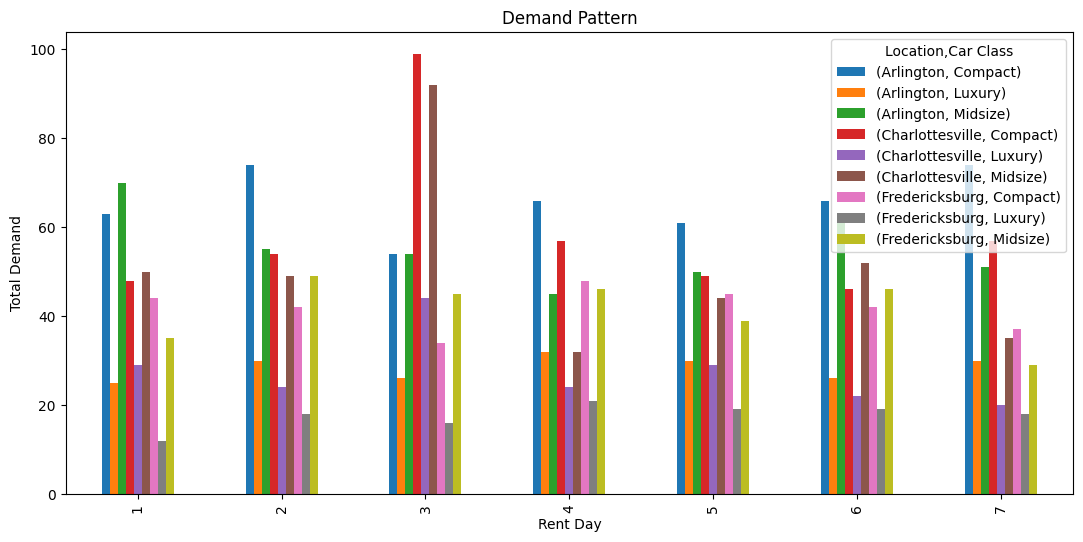

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# Transform the data for plotting
ag = multi_loc_data[['Location', 'Rent Day', 'Car Class', 'Demand']].groupby(['Location', 'Car Class', 'Rent Day'], as_index=False).agg('sum')
pv = ag[['Location', 'Car Class', 'Rent Day', 'Demand']].pivot_table(index='Rent Day', columns=['Location', 'Car Class'], values='Demand')
pv.plot.bar(figsize = (13, 6))

# Create the plot and add chart info
plt.title('Demand Pattern')
plt.ylabel('Total Demand')

# Display the plot
plt.show()

#### 3.4 Construct and Solve Two Models: With and Without Upgrade Substitutions
Again we will create and solve two models, this time for the multi-location scenario using truck transfers: with and without allowing upgrade substitutions.

In [ ]:
# Create a model allowing upgrades
upgrade_model_inputs = build_truck_multi_loc_model_inputs(multi_loc_data, init_car_inventory, init_truck_inventory,
                                                          transfer_costs, truck_capacity, upgrades)
upgrade_model = build_truck_multi_loc_model(*upgrade_model_inputs)

# Create another model that doesn't allow this
no_upgrade_model_inputs = build_truck_multi_loc_model_inputs(multi_loc_data, init_car_inventory, init_truck_inventory,
                                                          transfer_costs, truck_capacity, no_subs)
no_upgrade_model = build_truck_multi_loc_model(*no_upgrade_model_inputs)

# Solve the models - default solver is CBC
upgrade_model.solve()
no_upgrade_model.solve()

# Print the profits
print('Total Profit (Upgrade Model): ' + str(f"${value(upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[upgrade_model.status])
print('Total Profit (Non-Upgrade Model): ' + str(f"${value(no_upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[no_upgrade_model.status])

Total Profit (Upgrade Model): $327,984.00 --- Status: Optimal
Total Profit (Non-Upgrade Model): $319,559.00 --- Status: Optimal


#### 3.5 View the Optimal Allocation and Transportation Plan for the Upgrade Model

##### 3.5.1 Optimal Allocation

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

alloc_df=add_allocations(multi_loc_data, upgrade_model)
alloc_df.head() # Remove head to see the whole plan

,Location,Car Class,Rent Day,Return Day,Demand,Price,Compact,Midsize,Luxury
0,Fredericksburg,Compact,1,2,14,44,0.0,0.0,14.0
1,Fredericksburg,Compact,1,3,21,86,17.0,0.0,4.0
2,Fredericksburg,Compact,1,4,9,135,0.0,0.0,0.0
3,Fredericksburg,Midsize,1,2,10,63,0.0,0.0,10.0
4,Fredericksburg,Midsize,1,3,13,128,0.0,13.0,0.0


##### 3.5.2 Car Transfer Plan

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# Construct the data table for the transfer plan and display it
transp_items = dict([(x,y) for (x,y) in get_solved_model_vars(no_upgrade_model, 't').items() if y > 0]).items()
cs = [v[0][0] for v in transp_items]
froms = [v[0][1] for v in transp_items]
tos = [v[0][2] for v in transp_items]
day = [v[0][3] for v in transp_items]
qty = [v[1] for v in transp_items]
pd.DataFrame({'Car Class':cs, 'Day':day, 'From':froms, 'To':tos, 'Quantity':qty}).sort_values(by='Day')

,Car Class,Day,From,To,Quantity
0,Compact,0,Arlington,Charlottesville,1.0
28,Midsize,0,Fredericksburg,Arlington,50.0
19,Midsize,0,Arlington,Charlottesville,36.0
18,Luxury,0,Fredericksburg,Charlottesville,53.0
7,Compact,0,Fredericksburg,Arlington,21.0
29,Midsize,1,Fredericksburg,Arlington,10.0
4,Compact,1,Charlottesville,Arlington,13.0
8,Compact,1,Fredericksburg,Arlington,14.0
17,Luxury,1,Fredericksburg,Arlington,6.0
1,Compact,2,Arlington,Charlottesville,44.0


##### 3.5.3 Truck Transportation Plan

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# Construct the data table for the transfer plan and display it
transp_items = dict([(x,y) for (x,y) in get_solved_model_vars(no_upgrade_model, 'y').items() if y > 0]).items()
froms = [v[0][0] for v in transp_items]
tos = [v[0][1] for v in transp_items]
day = [v[0][2] for v in transp_items]
qty = [v[1] for v in transp_items]
pd.DataFrame({'Day':day, 'From':froms, 'To':tos, 'Quantity':qty}).sort_values(by='Day')

,Day,From,To,Quantity


## Scenario 4: Incorporating Dynamic Pricing and Fluctuating Demand
In this final scenario we will extend our previous model to accommodate price adjustments and fluctuating demand.
#### 4.1 Create a Function to Transform Raw Data Into Model Inputs
As we did in the previous scenarios, we must first transform the raw data into the appropriate inputs required by our model.

In [ ]:
# ---- DO NOT MODIFY THIS CODE BLOCK ---- #

# This function builds the inputs needed for the dynamic multi-location RM model.
# param demand_data_df: A data frame containing demand data
#                       (Location, Car Class, Rent Day, Return Day, Price, Demand, and Committed Demand)
# param init_car_inventory: A dict specifying initial inventory at each location of each car class.
#                           (ex. {('Fredericksburg, 'Compact'):35, ('Arlington','Midsize'):85})
# param init_truck_inventory: A dict specifying initial truck inventory at each location.
#                           (ex. {'Fredericksburg':3, 'Arlington':2})
# param transfer_costs: A dict of form {(<from location>, <to location>):<cost>}.
#                        Specifies the truck movement cost between each pair of locations.
# param truck_capacity: The max number of cars that a truck can carry per load.
# param substitutes: a list of form [(X, Y), ...] where X and Y are car
#                     classes and Y can be substituted for X
# returns: A tuple of input values in the order required by the model
def build_dynamic_multi_loc_model_inputs(dyn_demand_data_df, init_car_inventory, init_truck_inventory,
                                         transfer_costs, truck_capacity, substitutes):
    df = dyn_demand_data_df
    car_classes = set(df['Car Class'].tolist())
    locations = set(df['Location'].tolist())
    booking_slots = list(range(1, len(df) + 1))
    delta = max(df['Rent Day'].tolist())
    price = {k:p for (k,p) in zip(booking_slots, df['Price'].tolist())}
    demand = {k:d for (k,d) in zip(booking_slots, df['Demand'].tolist())}
    committed_demand = {k:d for (k,d) in zip(booking_slots, df['Committed Demand'].tolist())}
    D, A = {}, {}
    for i,j in [(a,b) for a in locations for b in range(1, delta + 1)]:
        D[i,j] = [k for k in booking_slots if df.loc[k-1, 'Location'] == i and df.loc[k-1, 'Rent Day'] == j]
        A[i,j] = [k for k in booking_slots if df.loc[k-1, 'Location'] == i and df.loc[k-1, 'Return Day'] == j]
    subs = {h:[j for (i, j) in substitutes + [(k,k) for k in car_classes] if i == h] for h in car_classes}
    satisfy = {(h,k):0 for h in car_classes for k in booking_slots}
    for k in booking_slots:
        base_class = df.loc[k-1, 'Car Class']
        for h in subs[base_class]:
            satisfy[h,k] = 1
    I0 = init_car_inventory
    T0 = init_truck_inventory
    KT = truck_capacity
    return car_classes, locations, booking_slots, delta, price, demand, committed_demand, transfer_costs, D, A, I0, satisfy, T0, KT

#### 4.2 Create a Function to Construct a PuLP Model Instance from a Set of Inputs
As before, we need to build the model inputs into a PuLP model instance that can be solved.  
**TODO:** In the code block below, please complete the model implementation. Make sure to follow instructions on what to modify.

In [ ]:
# This function creates a PuLP model for the dynamic multi-location scenario.
# param C: The set of car classes. A list or set.
# param L: The set of locations. A list or set.
# param S: The set of booking slots. A list or set.
# param delta: The number of days in the planning horizon (last rent day). An integer.
# param p: The price for each booking slot. A list.
# param d: The demand for each booking slot. A list.
# param dc: The committed demand for each booking slot. A list.
# param c: The vehicle transfer costs. A dict of form {(<car class>, <from location>, <to location>):<cost>}
# param D: A dict of form {(<location>, <rental day>):[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots rent out cars on each day.
# param A: A dict of form {(<location>, <arrival day>):[<slot 1>, <slot 2>, ..]} - specifies which
#           booking slots have cars being returned on each day.
# param I0: A dict of form {(<car class>, <location>):units} - specifies how many cars of each type we have
#            at each location at the beginning of the horizon
# param v: A dict of form {(<car_class>, <booking_slot>):B} where B = 0 | 1. Specifies
#           whether a car class can be allocated to a booking slot.
# param T0: A dict of form {<location>:units} - specifies how many trucks we have
#            at each location at the beginning of the horizon
# param KT: The truck capacity - i.e., max number of cars it can carry per load
# returns: a PuLP model
def build_dynamic_multi_loc_model(C, L, S, delta, p, d, dc, c, D, A, I0, v, T0, KT):
    # Compute a tight Big M:
    M = max(d)

    # Specify the decision variables:
    x = LpVariable.dicts("x", (C, S), 0, None, LpInteger)
    y = LpVariable.dicts("y", (L, L, list(range(delta))), 0, None, LpInteger)
    I = LpVariable.dicts("I", (C, L, list(range(delta+1))), 0, None, LpInteger)
    t = LpVariable.dicts("t", (C, L, L, list(range(delta))), 0, None, LpInteger)
    T = LpVariable.dicts("T", (L, list(range(delta+1))), 0, None, LpInteger)

    # Initialize the model and specify the objective function (exp. 1):
    mod = LpProblem("TruckTransportMultiLocRC", LpMaximize)
    mod += (lpSum(p[k] * x[h][k] for h in C for k in S)
            - lpSum(c[i,ip] * y[i][ip][j] for i in L for ip in L for j in range(delta))), 'Profit'

    for k in S:
        # Constraint set 2a - Ensure all committed demand is met:
        # --- TODO: Insert a constraint here to ensure all committed demand is met.
        # Constraint set 2b - Don't allocate more cars than demand to any booking slot:
        mod += lpSum([x[h][k] for h in C]) <= d[k]
    for h in C:
        for k in S:
            # Constraint set 3 - Ensure no invalid substitutions:
            mod += x[h][k] <= M * v[h,k]
        for i in L:
            # Set initial car inventories
            mod += I[h][i][0] == I0[h,i]
            for j in range(1, delta+1):
                # Constraint set 4 - Car inventory flow balance
                mod += I[h][i][j] == (I[h][i][j-1]
                                      - lpSum(t[h][i][ip][j-1] for ip in L)
                                      + lpSum(t[h][ip][i][j-1] for ip in L)
                                      - lpSum(x[h][k] for k in D[i,j])
                                      + lpSum(x[h][k] for k in A[i,j]))
    for i in L:
        # Set initial truck inventories
        mod += T[i][0] == T0[i]
        for j in range(delta):
            # Constraint set 5 - Truck transfer limit
            mod += lpSum(y[i][ip][j] for ip in L) <= T[i][j]
        for j in range(1,delta+1):
            # Constraint set 6 - Truck inventory flow balance
            mod += T[i][j] == (T[i][j-1]
                               - lpSum(y[i][ip][j-1] for ip in L)
                               + lpSum(y[ip][i][j-1] for ip in L))
        for ip in L:
            for j in range(delta):
                # Constraint set 7 - Transfers don't exceed truck capacity/availability
                mod += lpSum(t[h][i][ip][j] for h in C) <= KT * y[i][ip][j]
    return mod

#### 4.3 Specify Initial Car/Transport Truck Inventories & Transfer Costs, Read In Demand Data
Here we will specify the scenario parameters. Since we now have to pay attention to committed demand, we will read in a new demand data set that includes this.

In [ ]:
# Here we will use the same scenario parameters as before.

# Specify the initial car inventory.
init_car_inventory = {('Compact','Fredericksburg'):35, ('Midsize','Fredericksburg'):85, ('Luxury','Fredericksburg'):90,
                      ('Compact','Charlottesville'):15, ('Midsize','Charlottesville'):35, ('Luxury','Charlottesville'):20,
                      ('Compact','Arlington'):35, ('Midsize','Arlington'):85, ('Luxury','Arlington'):50}

# Specify the initial truck inventory positioning - 1 in each location
init_truck_inventory = {'Fredericksburg':1, 'Charlottesville':1, 'Arlington':1}

# Specify the transfer cost - $750 per truck movement
locs = ['Fredericksburg', 'Charlottesville', 'Arlington']
classes = ['Compact', 'Midsize', 'Luxury']
transfer_costs = {(i,j):0 if i == j else 750 for h in classes for i in locs for j in locs}

# Each truck can carry 8 cars
truck_capacity = 8

# Read in and inspect the demand data - note the new column for committed demand
dynamic_multi_loc_data = pd.read_csv('Rental-Car-Revenue-Management/dynamic-multi-loc-rm.csv')
dynamic_multi_loc_data.head()

,Location,Car Class,Rent Day,Return Day,Demand,Price,Committed Demand
0,Fredericksburg,Compact,1,2,10,52,3
1,Fredericksburg,Compact,1,3,19,98,1
2,Fredericksburg,Compact,1,4,12,132,4
3,Fredericksburg,Midsize,1,2,6,59,3
4,Fredericksburg,Midsize,1,3,15,130,7


#### 4.4 Construct and Solve Two Models: With and Without Upgrade Substitutions
Again we will create and solve two models, this time for the multi-location scenario using truck transfers: with and without allowing upgrade substitutions.

In [ ]:
# Create a model allowing upgrades
upgrade_model_inputs = build_dynamic_multi_loc_model_inputs(dynamic_multi_loc_data, init_car_inventory, init_truck_inventory,
                                                            transfer_costs, truck_capacity, upgrades)
upgrade_model = build_dynamic_multi_loc_model(*upgrade_model_inputs)

# Create another model that doesn't allow this
no_upgrade_model_inputs = build_dynamic_multi_loc_model_inputs(dynamic_multi_loc_data, init_car_inventory, init_truck_inventory,
                                                               transfer_costs, truck_capacity, no_subs)
no_upgrade_model = build_dynamic_multi_loc_model(*no_upgrade_model_inputs)

# Solve the models - default solver is CBC
upgrade_model.solve()
no_upgrade_model.solve()

# Print the profits
print('Total Profit (Upgrade Model): ' + str(f"${value(upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[upgrade_model.status])
print('Total Profit (Non-Upgrade Model): ' + str(f"${value(no_upgrade_model.objective):,.2f}"),
      "--- Status:", LpStatus[no_upgrade_model.status])

Total Profit (Upgrade Model): $292,677.00 --- Status: Optimal
Total Profit (Non-Upgrade Model): $279,959.00 --- Status: Optimal
